In [1]:
import base64, json, requests, boto3, xarray as xr, pandas as pd
from datetime import datetime, timezone
from getpass import getpass
from dotenv import load_dotenv
import os
load_dotenv()

# ===== 1. AUTENTICACIÓN NASA EARTHDATA LOGIN =====

def get_tempo_credentials(username, password,
                          endpoint="https://data.asdc.earthdata.nasa.gov/s3credentials"):
    """Devuelve credenciales temporales (~1h) para leer datos TEMPO desde AWS S3"""
    login_resp = requests.get(endpoint, allow_redirects=False)
    login_resp.raise_for_status()

    print(login_resp.headers)
    auth = f"{username}:{password}"
    encoded_auth = base64.b64encode(auth.encode("ascii"))

    auth_redirect = requests.post(
        login_resp.headers["location"],
        data={"credentials": encoded_auth},
        headers={"Origin": endpoint},
        allow_redirects=False
    )
    auth_redirect.raise_for_status()

    final = requests.get(auth_redirect.headers["location"], allow_redirects=False)
    results = requests.get(endpoint, cookies={'accessToken': final.cookies['accessToken']})
    results.raise_for_status()
    print(results.content)
    return json.loads(results.content)

# --- USUARIO Y CONTRASEÑA EDL ---
edl_user = os.getenv("EDL_USER")
edl_pass = os.getenv("EDL_PASS")

creds = get_tempo_credentials(edl_user, edl_pass)
print("Credenciales obtenidas. Expiran:", creds["expiration"])


{'Content-Type': 'text/plain; charset=utf-8', 'Content-Length': '223', 'Connection': 'keep-alive', 'Date': 'Mon, 06 Oct 2025 00:13:47 GMT', 'x-amzn-Remapped-Date': 'Mon, 06 Oct 2025 00:13:47 GMT', 'x-amzn-RequestId': '85f764a6-9995-419c-80fd-76a475d5e5ee', 'x-amzn-Remapped-x-amzn-RequestId': '95bc7af3-098a-49e2-bc0c-799cc78ae322', 'X-XSS-Protection': '1; mode=block', 'access-control-allow-origin': '*', 'strict-transport-security': 'max-age=31536000; includeSubDomains; preload', 'x-amzn-Remapped-Content-Length': '223', 'X-Frame-Options': 'SAMEORIGIN', 'x-amzn-Remapped-x-amzn-Remapped-date': 'Mon, 06 Oct 2025 00:13:47 GMT', 'x-amzn-Remapped-Connection': 'keep-alive', 'x-amz-apigw-id': 'R_51WGRyPHcEDqA=', 'vary': 'Accept', 'x-amzn-Remapped-Server': 'Server', 'X-Content-Type-Options': 'nosniff', 'location': 'https://urs.earthdata.nasa.gov/oauth/authorize?client_id=F2TN1UIAkP8pHBZ2yWVWkQ&redirect_uri=https%3A%2F%2Fdata.asdc.earthdata.nasa.gov%2Fredirect&response_type=code&state=%2Fs3credent

In [56]:
import boto3
from datetime import datetime, timedelta, timezone

def get_latest_tempo_file(creds, target_dt):
    """
    Busca el archivo TEMPO más reciente anterior o igual a la fecha dada.
    Si no hay en ese día, retrocede hasta encontrar uno.
    """
    s3 = boto3.client(
        "s3",
        aws_access_key_id=creds["accessKeyId"],
        aws_secret_access_key=creds["secretAccessKey"],
        aws_session_token=creds["sessionToken"]
    )

    bucket = "asdc-prod-protected"

    for _ in range(5):  # intenta hasta 5 días hacia atrás
        prefix = f"TEMPO/TEMPO_NO2_L2_V04/{target_dt:%Y.%m.%d}/"
        print(f"🔎 Buscando en {prefix}...")

        resp = s3.list_objects_v2(Bucket=bucket, Prefix=prefix)

        # Si hay resultados
        if "Contents" in resp:
            # Filtrar archivos .nc (evitar .dmrpp)
            nc_files = [obj for obj in resp["Contents"] if obj["Key"].endswith(".nc")]
            if nc_files:
                # Ordenar por hora dentro del día (LastModified)
                latest = sorted(nc_files, key=lambda x: x["LastModified"], reverse=True)[0]
                print("✅ Archivo encontrado:", latest["Key"])
                return latest

        # Si no hay archivos ese día, retrocede 1 día
        target_dt -= timedelta(days=1)

    print("❌ No se encontraron archivos en los últimos 5 días.")
    return None


In [59]:
# creds: tu dict con accessKeyId, secretAccessKey, sessionToken
# target_dt: datetime enviado desde el frontend (ISO, UTC)

js_payload = json.dumps({
    "datetime": "2025-10-04T14:27:00.000Z"   # <- Simulado desde new Date()
})
data = json.loads(js_payload)
iso_str = data["datetime"]
target_dt = datetime.fromisoformat(iso_str.replace("Z", "+00:00"))  # UTC aware
print("🕒 Fecha recibida del frontend:", target_dt)

#fecha = datetime(2025, 10, 4, 16, 30, tzinfo=timezone.utc)
archivo = get_latest_tempo_file(creds, target_dt)

if archivo:
    print("Archivo más reciente:")
    print(archivo["Key"])
    print("Fecha de modificación:", archivo["LastModified"])


🕒 Fecha recibida del frontend: 2025-10-04 14:27:00+00:00
🔎 Buscando en TEMPO/TEMPO_NO2_L2_V04/2025.10.04/...
✅ Archivo encontrado: TEMPO/TEMPO_NO2_L2_V04/2025.10.04/TEMPO_NO2_L2_V04_20251004T133103Z_S004G01.nc
Archivo más reciente:
TEMPO/TEMPO_NO2_L2_V04/2025.10.04/TEMPO_NO2_L2_V04_20251004T133103Z_S004G01.nc
Fecha de modificación: 2025-10-04 17:22:43+00:00


In [60]:
import boto3
from datetime import datetime, timedelta, timezone

def get_latest_tempo_file_for_region(s3, bucket, target_dt, region):
    """
    Devuelve el archivo TEMPO más reciente para una región G01-G09 en o antes de la fecha dada.
    Retrocede días si no hay datos en el día.
    """
    for _ in range(5):  # retrocede hasta 5 días
        prefix = f"TEMPO/TEMPO_NO2_L2_V04/{target_dt:%Y.%m.%d}/"
        resp = s3.list_objects_v2(Bucket=bucket, Prefix=prefix)

        if "Contents" in resp:
            # Filtramos los .nc del tile Gxx
            nc_files = [
                obj for obj in resp["Contents"]
                if obj["Key"].endswith(f"{region}.nc")
            ]
            if nc_files:
                # Último por hora
                latest = sorted(nc_files, key=lambda x: x["LastModified"], reverse=True)[0]
                return {
                    "region": region,
                    "Key": latest["Key"],
                    "LastModified": latest["LastModified"].isoformat()
                }

        # Si no hay archivos ese día, retrocede uno
        target_dt -= timedelta(days=1)

    # Si no hay resultados
    return {"region": region, "Key": None, "LastModified": None}


def get_latest_tempo_all_regions(creds, target_dt):
    """
    Devuelve el archivo más reciente para las 9 regiones G01-G09
    en o antes de la fecha/hora indicada.
    """
    s3 = boto3.client(
        "s3",
        aws_access_key_id=creds["accessKeyId"],
        aws_secret_access_key=creds["secretAccessKey"],
        aws_session_token=creds["sessionToken"]
    )

    bucket = "asdc-prod-protected"
    regions = [f"G0{i}" for i in range(1, 10)]
    results = []

    for region in regions:
        print(f"🔎 Buscando región {region}...")
        res = get_latest_tempo_file_for_region(s3, bucket, target_dt, region)
        if res["Key"]:
            print(f"✅ {region}: {res['Key']}")
        else:
            print(f"⚠️  {region}: sin datos recientes")
        results.append(res)

    return results


In [63]:
from datetime import datetime, timezone

js_payload = json.dumps({
    "datetime": "2025-10-04T14:27:00.000Z"   # <- Simulado desde new Date()
})
data = json.loads(js_payload)
iso_str = data["datetime"]
target_dt = datetime.fromisoformat(iso_str.replace("Z", "+00:00"))  # UTC aware
print("🕒 Fecha recibida del frontend:", target_dt)

archivos = get_latest_tempo_all_regions(creds, target_dt)

print("\n🗂️ Resultados finales:")
for a in archivos:
    print(a)

🕒 Fecha recibida del frontend: 2025-10-04 14:27:00+00:00
🔎 Buscando región G01...
✅ G01: TEMPO/TEMPO_NO2_L2_V04/2025.10.04/TEMPO_NO2_L2_V04_20251004T133103Z_S004G01.nc
🔎 Buscando región G02...
✅ G02: TEMPO/TEMPO_NO2_L2_V04/2025.10.04/TEMPO_NO2_L2_V04_20251004T133743Z_S004G02.nc
🔎 Buscando región G03...
✅ G03: TEMPO/TEMPO_NO2_L2_V04/2025.10.04/TEMPO_NO2_L2_V04_20251004T134423Z_S004G03.nc
🔎 Buscando región G04...
✅ G04: TEMPO/TEMPO_NO2_L2_V04/2025.10.04/TEMPO_NO2_L2_V04_20251004T135101Z_S004G04.nc
🔎 Buscando región G05...
✅ G05: TEMPO/TEMPO_NO2_L2_V04/2025.10.04/TEMPO_NO2_L2_V04_20251004T135738Z_S004G05.nc
🔎 Buscando región G06...
✅ G06: TEMPO/TEMPO_NO2_L2_V04/2025.10.04/TEMPO_NO2_L2_V04_20251004T140415Z_S004G06.nc
🔎 Buscando región G07...
✅ G07: TEMPO/TEMPO_NO2_L2_V04/2025.10.04/TEMPO_NO2_L2_V04_20251004T141053Z_S004G07.nc
🔎 Buscando región G08...
✅ G08: TEMPO/TEMPO_NO2_L2_V04/2025.10.04/TEMPO_NO2_L2_V04_20251004T141730Z_S004G08.nc
🔎 Buscando región G09...
✅ G09: TEMPO/TEMPO_NO2_L2_V04/

In [64]:
def tempo_file_to_df(local_path):
    """
    Abre un archivo TEMPO .nc y devuelve un DataFrame limpio con:
    lon, lat, no2, q (flag de calidad)
    """
    try:
        nc = Dataset(local_path, "r")

        # Extraer variables dentro de los grupos
        no2_trop = nc.groups["product"].variables["vertical_column_troposphere"][:]
        lat = nc.groups["geolocation"].variables["latitude"][:]
        lon = nc.groups["geolocation"].variables["longitude"][:]
        flag = nc.groups["product"].variables["main_data_quality_flag"][:]

        # Filtrar valores inválidos
        no2_trop = np.where(flag > 1, np.nan, no2_trop)
        no2_trop = np.where(no2_trop < 0, np.nan, no2_trop)

        # Crear DataFrame
        df = pd.DataFrame({
            "lon": lon.flatten(),
            "lat": lat.flatten(),
            "no2": no2_trop.flatten(),
            "q": flag.flatten()
        }).dropna(subset=["no2"])

        df["source"] = os.path.basename(local_path)  # opcional: archivo de origen

        nc.close()
        return df

    except Exception as e:
        print(f"⚠️ Error procesando {local_path}: {e}")
        return pd.DataFrame()

In [65]:
def merge_tempo_tiles(results, creds, download_dir="tempo_tiles"):
    """
    Descarga, procesa y concatena los 9 tiles G01–G09 en un solo DataFrame.
    """
    import boto3, os

    s3 = boto3.client(
        "s3",
        aws_access_key_id=creds["accessKeyId"],
        aws_secret_access_key=creds["secretAccessKey"],
        aws_session_token=creds["sessionToken"]
    )

    bucket = "asdc-prod-protected"
    os.makedirs(download_dir, exist_ok=True)

    dfs = []
    for region_data in results:
        key = region_data["Key"]
        if not key:
            print(f"⚠️ {region_data['region']} sin archivo, se salta.")
            continue

        filename = os.path.join(download_dir, os.path.basename(key))
        print(f"⬇️ Descargando {region_data['region']} → {filename}")
        s3.download_file(bucket, key, filename)

        df = tempo_file_to_df(filename)
        print(f"   ✅ {region_data['region']} → {len(df):,} filas")
        dfs.append(df)

    # Concatenar todos los DataFrames
    if dfs:
        full_df = pd.concat(dfs, ignore_index=True)
        print(f"\n🌍 DataFrame combinado con {len(full_df):,} filas totales.")
        return full_df
    else:
        print("❌ No se generaron DataFrames válidos.")
        return pd.DataFrame()


In [66]:
# results = salida del get_latest_tempo_all_regions()
# creds = tus credenciales AWS temporales

full_df = merge_tempo_tiles(archivos, creds)

# Mostrar primeras filas
print(full_df.head())


⬇️ Descargando G01 → tempo_tiles/TEMPO_NO2_L2_V04_20251004T133103Z_S004G01.nc
   ✅ G01 → 215,642 filas
⬇️ Descargando G02 → tempo_tiles/TEMPO_NO2_L2_V04_20251004T133743Z_S004G02.nc
   ✅ G02 → 222,959 filas
⬇️ Descargando G03 → tempo_tiles/TEMPO_NO2_L2_V04_20251004T134423Z_S004G03.nc
   ✅ G03 → 226,986 filas
⬇️ Descargando G04 → tempo_tiles/TEMPO_NO2_L2_V04_20251004T135101Z_S004G04.nc
   ✅ G04 → 236,230 filas
⬇️ Descargando G05 → tempo_tiles/TEMPO_NO2_L2_V04_20251004T135738Z_S004G05.nc
   ✅ G05 → 241,410 filas
⬇️ Descargando G06 → tempo_tiles/TEMPO_NO2_L2_V04_20251004T140415Z_S004G06.nc
   ✅ G06 → 244,585 filas
⬇️ Descargando G07 → tempo_tiles/TEMPO_NO2_L2_V04_20251004T141053Z_S004G07.nc
   ✅ G07 → 226,633 filas
⬇️ Descargando G08 → tempo_tiles/TEMPO_NO2_L2_V04_20251004T141730Z_S004G08.nc
   ✅ G08 → 199,863 filas
⬇️ Descargando G09 → tempo_tiles/TEMPO_NO2_L2_V04_20251004T142407Z_S004G09.nc
   ✅ G09 → 132,582 filas

🌍 DataFrame combinado con 1,946,890 filas totales.
         lon        l

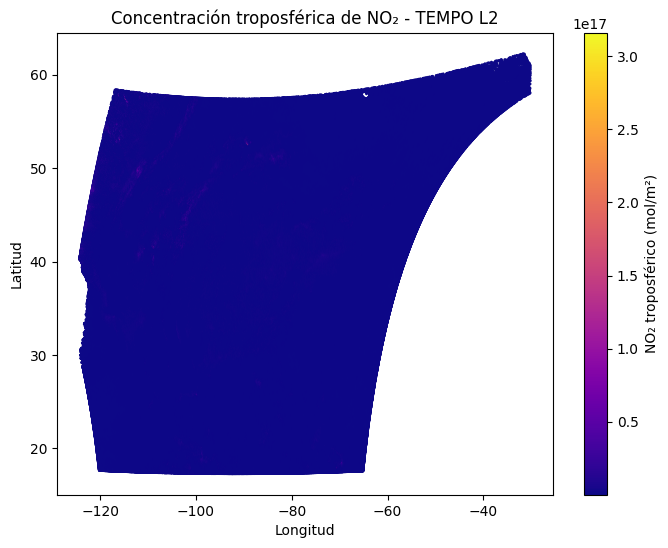

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(full_df["lon"], full_df["lat"], c=full_df["no2"], cmap="plasma", s=1)
plt.colorbar(label="NO₂ troposférico (mol/m²)")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.title("Concentración troposférica de NO₂ - TEMPO L2")
plt.show()


In [69]:
full_df.to_csv("/Users/armandohernandez/Documents/no2_full.csv", index=False)

In [74]:
import numpy as np
import pandas as pd
from pyproj import Geod
from scipy.spatial import cKDTree

geod = Geod(ellps="WGS84")

def nearest_neighbor_spacing(df: pd.DataFrame, group_col: str = None):
    """
    Estima la separación típica como distancia al vecino más cercano.
    Si `group_col` (p. ej. 'region' o 'source') está, calcula por grupo y promedia.
    Devuelve mediana (km) y percentiles.
    """
    def nn_for_block(block):
        # KDTree en grados para encontrar candidato NN
        pts = block[["lon","lat"]].to_numpy()
        if len(pts) < 2:
            return np.array([])
        tree = cKDTree(pts)
        # k=2: el primer vecino es el propio punto (dist=0), el segundo es el NN real
        dists_idx = tree.query(pts, k=2)[1][:,1]  # índices del NN
        nn_pts = pts[dists_idx]

        # distancia geodésica precisa (m)
        _, _, d_m = geod.inv(pts[:,0], pts[:,1], nn_pts[:,0], nn_pts[:,1])
        d_km = d_m / 1000.0
        d_km = d_km[np.isfinite(d_km)]
        return d_km

    if group_col and group_col in df.columns:
        all_d = []
        for _, g in df.groupby(group_col):
            d_km = nn_for_block(g)
            if d_km.size:
                all_d.append(d_km)
        if not all_d:
            return None
        d = np.concatenate(all_d)
    else:
        d = nn_for_block(df)

    return {
        "median_nn_km": float(np.nanmedian(d)),
        "p10_nn_km": float(np.nanpercentile(d, 10)),
        "p90_nn_km": float(np.nanpercentile(d, 90)),
        "n_points": int(d.size)
    }

# Ejemplo:


In [75]:
res = nearest_neighbor_spacing(full_df, group_col="source")  # o "region" si la agregaste
print(res)


{'median_nn_km': 2.024443926874329, 'p10_nn_km': 1.6828012989665286, 'p90_nn_km': 3.212957462043284, 'n_points': 1946890}
